# Standard CV-based nuclei segmentation

---

## 0. Environmental setup

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from nd2reader import ND2Reader
import os
from PIL import Image 
import cc3d
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from skimage.morphology import label
from skimage.measure import regionprops
from typing import List, Tuple
import SimpleITK as sitk
import tifffile

%matplotlib notebook

In [2]:
plt.rcParams['figure.figsize'] = [9, 7.5]
#plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

In [3]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

In [4]:
def multi_slice_viewer(volume, cmap:str=None):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index], cmap=cmap)
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])
    ax.set_title('z_level: {}'.format(ax.index))

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    ax.set_title('z_level: {}'.format(ax.index))

In [5]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    #apply gamma correction using the lookup table
    return cv.LUT(image, table)

In [6]:
def bbox_2d(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

In [ ]:
def filter_nuclei_by_size(nuclei_dicts, microns_per_pixel:float, min_volume:float=None, 
                          max_volume:float=None)->Tuple[List]:
    filtered = []
    filtered_out = []
    for i in range(len(nuclei_dicts)):
        volume = nuclei_dicts[i]['props'].filled_area * (microns_per_pixel) ** 3
        print(volume)
        if min_volume is not None and volume < min_volume:
            filtered_out.append(nuclei_dicts[i])
        elif volume is not None and volume > max_volume:
            filtered_out.append(nuclei_dicts[i])
        else:
            filtered.append(nuclei_dicts[i])
    return filtered, filtered_out

In [ ]:
def get_conservative_nuclear_crops(labels:np.ndarray, intensity_image:np.ndarray, xbuffer:int=0, 
                                   ybuffer:int=0, zbuffer:int=1)->List[dict]:
    nuclear_properties = regionprops(labels, intensity_image=intensity_image)
    nuclei_dicts = []
    
    for properties in nuclear_properties:
        depth, width, height = intensity_image.shape
        zmin, xmin, ymin, zmax, xmax, ymax = properties.bbox
        zmin = max(0, zmin-zbuffer)
        xmin = max(0, xmin-xbuffer)
        ymin = max(0, ymin-ybuffer)
        zmax = min(zmax + zbuffer+1, depth)
        xmax = min(xmax + xbuffer+1, width)
        ymax = min(ymax + ybuffer+1, height)
        nuclei_dicts.append({'image':intensity_image[zmin:zmax, xmin:xmax, ymin:ymax], 'props':properties})
    return nuclei_dicts
    

In [ ]:
def get_colored_label_image_for_3d(image:np.ndarray, labels:np.ndarray)->np.ndarray:
    depth = image.shape[0]
    colored_label_image = []
    for i in range(depth):
        colored_label_image.append(label2rgb(labels[i,:,:], image=image[i,:,:], bg_label=0))
    return np.array(colored_label_image)

In [7]:
def nd2_to_npy(nd2_file:str):
    """Function that returns a dictionary that includes the images for each channel of the .nd2 file 
    and the meta-information"""
    with ND2Reader(nd2_file) as reader:
        metadata = reader.metadata
        width, height, depth = reader.sizes['x'], reader.sizes['y'], reader.sizes['z']
        channels = metadata['channels']
        #reader.bundle_axes = 'zxy'
        image = np.zeros([depth, height, width, depth], dtype=np.float64)
        channel_images = []
        for idx, channel in enumerate(channels):
            reader.default_coords['c'] = idx
            for i in range(depth):
                image[i, :, :, idx] = reader[i]
        data_dict = {'channels':channels, 'image':image, 'metadata':metadata}
        return data_dict

In [8]:
def save_npy_as_tiff(frames:np.ndarray, path:str):
    """ To be implemented """
    tifffile.imsave(path, frames)

---
## 1. Read in the data

Let us use a sample file to visualize the pipeline.

In [9]:
outputdir = '/home/daniel/Desktop/processing'
os.makedirs(outputdir, exist_ok=True)


nd2_file = '/home/daniel/Downloads/11J1_CD4T_488Coro1A_555RPL10A_D001.nd2'
#nd2_file ='/home/daniel/Downloads/M1_488epcam_D001.nd2'
data_dict = nd2_to_npy(nd2_file)
print(data_dict['image'].shape)
data_dict['channels']

(21, 1024, 1024, 21)


['DAPI', 'Alexa 488 water', 'Alx546']

---

## 2. Segmentation pipeline

Before we actually start we transform the data such that the data type is given by unsigned integers.


In [10]:
src = data_dict['image'][:,:,:, data_dict['channels'].index("DAPI")]

<IPython.core.display.Javascript object>


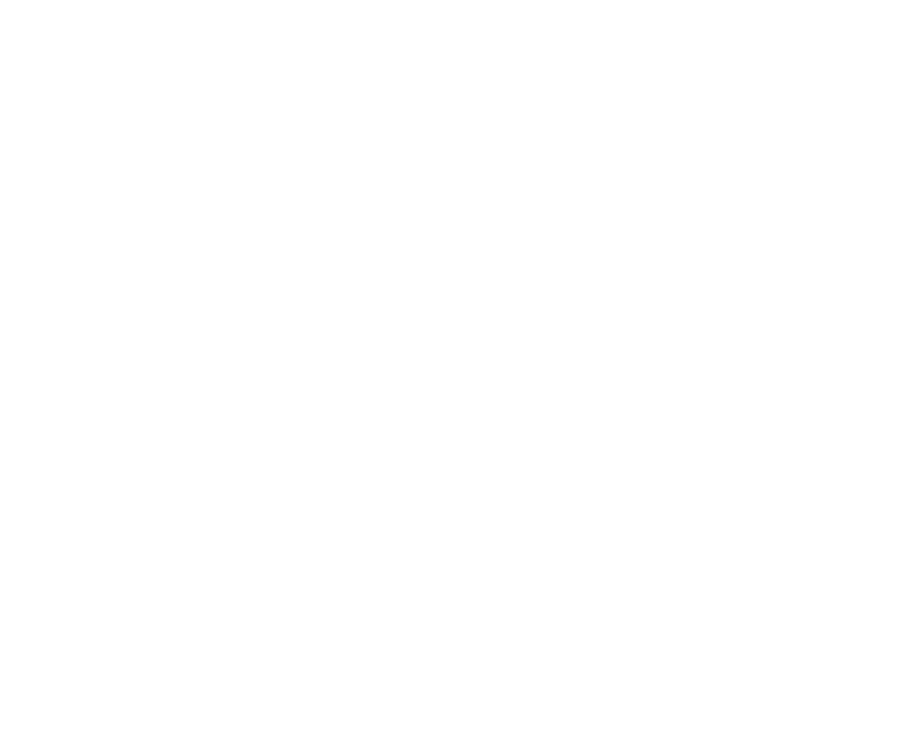

In [11]:
multi_slice_viewer(src, cmap='gray')

---
### 2.a. Thresholding and Connect

This pipeline realizes a standard segmentation pipeline based on thresholding and the Watershed algorithm

#### 2a. i) Normalize image and enhance contrast

We first normalize the image layerwise to enhance the contrast.

In [12]:
normalized_img = src/src.max()
normalized_img *= 255
normalized_img = normalized_img.astype(np.uint8)

In [13]:
contrast_rate = 1
adjusted_img = np.clip(normalized_img * contrast_rate, 0, 255)

<IPython.core.display.Javascript object>


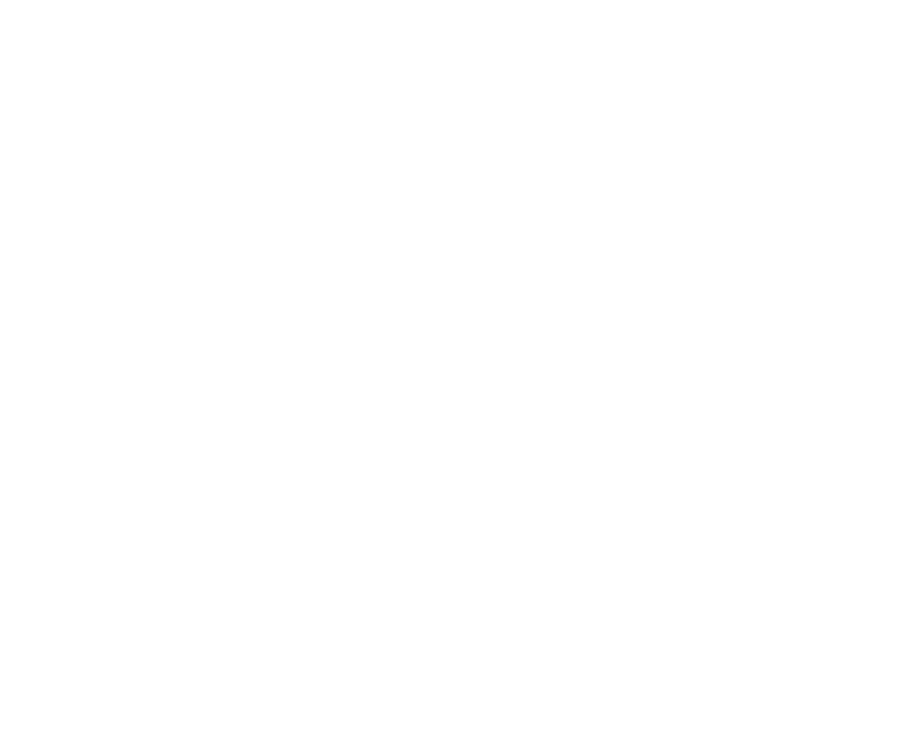

In [14]:
multi_slice_viewer(adjusted_img, 'gray')

#### 2a. ii) Binarize the image

In [15]:
thresh = threshold_otsu(adjusted_img)
binary = adjusted_img > thresh
binary = np.uint8(binary)

<IPython.core.display.Javascript object>


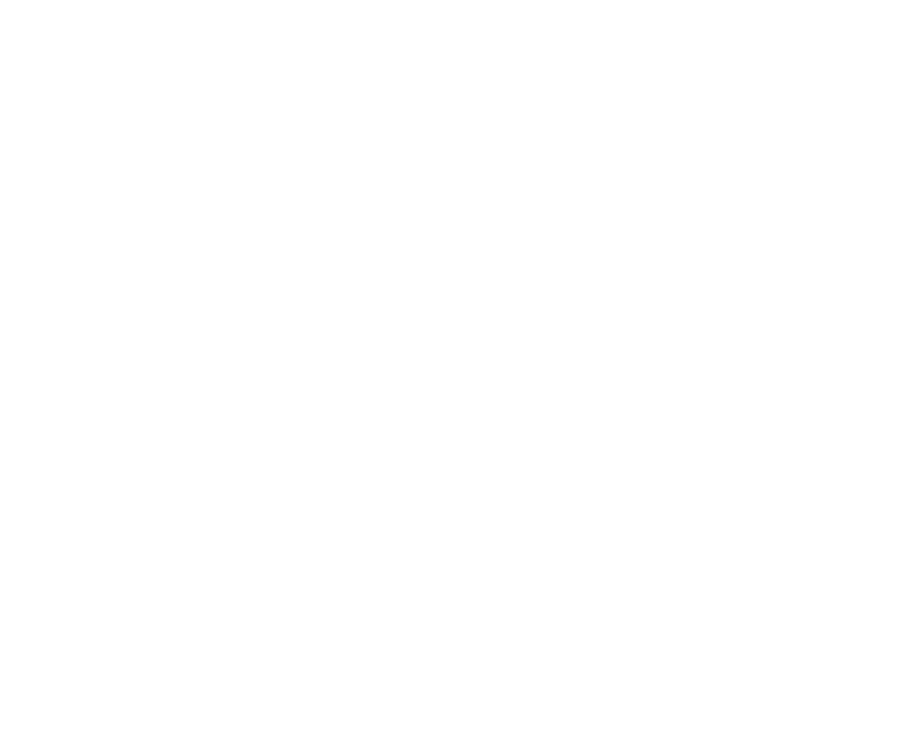

In [16]:
multi_slice_viewer(binary, 'gray')

#### 2a. ii) Remove small noise and small holes
We now remove any white small noise in the image (although there seems to be none except for that induced by cut off nuclei at the border of the image) and fill small holes using morphological opening and closing respectively.

In [17]:
kernel = np.ones((3,3), np.uint8)
closing = cv.morphologyEx(binary.transpose(), cv.MORPH_CLOSE, kernel, iterations=10).transpose()

<IPython.core.display.Javascript object>


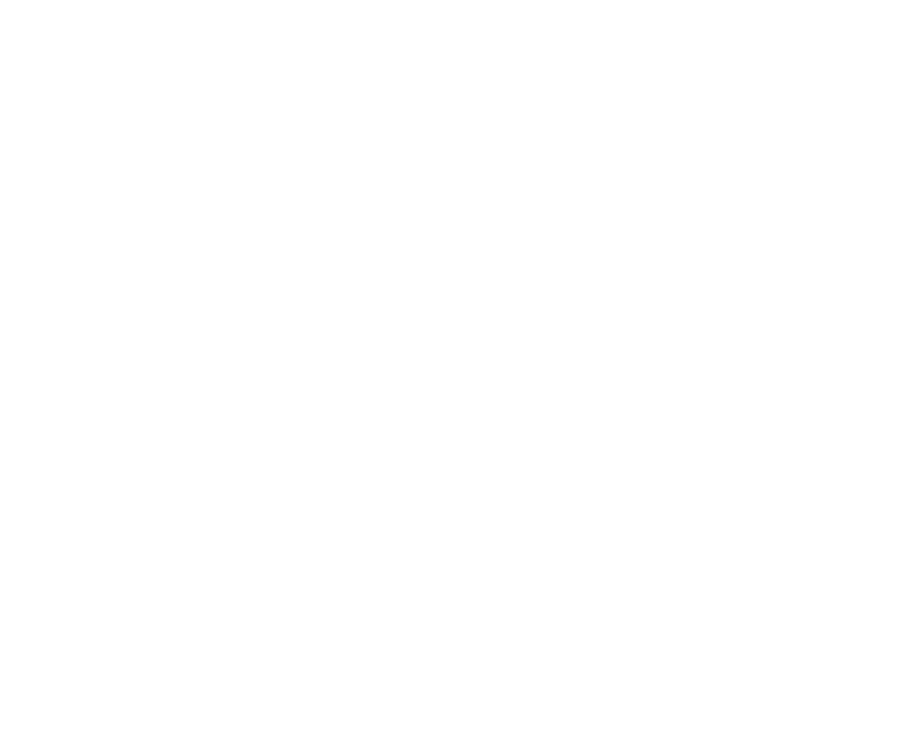

In [18]:
multi_slice_viewer(closing, 'gray')

---
#### 2a. iii) Mark objects

We now label the objects that we found. 

In [19]:
# from skimage.morphology import label
import scipy

labels, n_nuclei = label(closing, return_num=True, connectivity=3)

# connectivity = 26 # only 26, 18, and 6 are allowed
# labels_out = cc3d.connected_components(closing, connectivity=connectivity)

In [61]:
nuclei_region_props = regionprops(labels, intensity_image=normalized_img)
nuclei_region_props[0].convex_image.shape

(16, 58, 56)

<IPython.core.display.Javascript object>


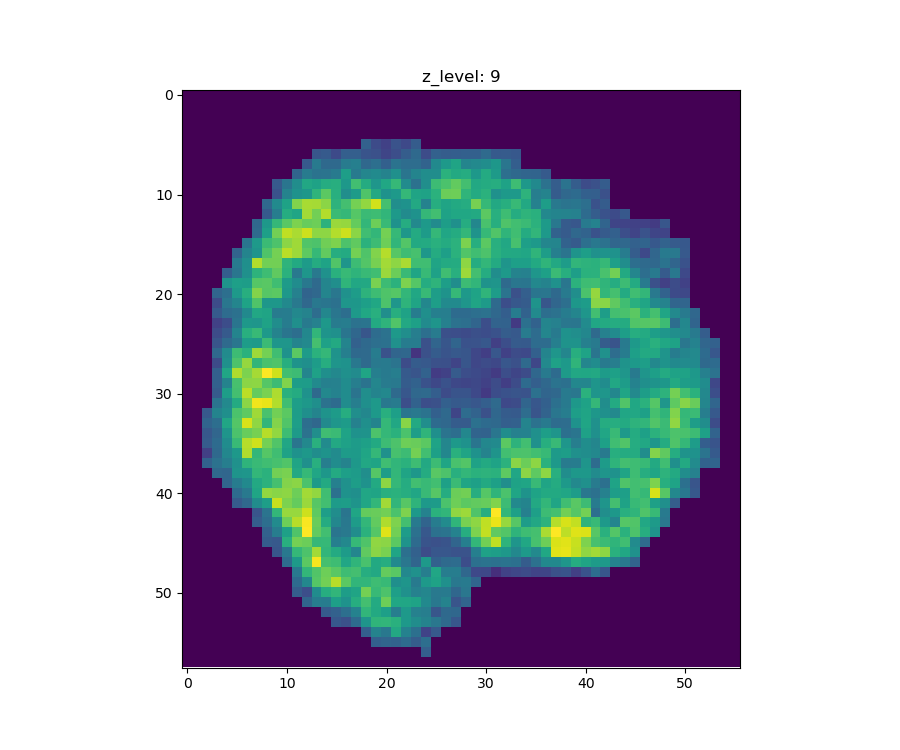

In [63]:
multi_slice_viewer(nuclei_region_props[0].intensity_image)

In [21]:
colored_label_image = get_colored_label_image_for_3d(normalized_img, labels)

In [22]:
colored_label_image.shape

(21, 1024, 1024, 3)

<IPython.core.display.Javascript object>


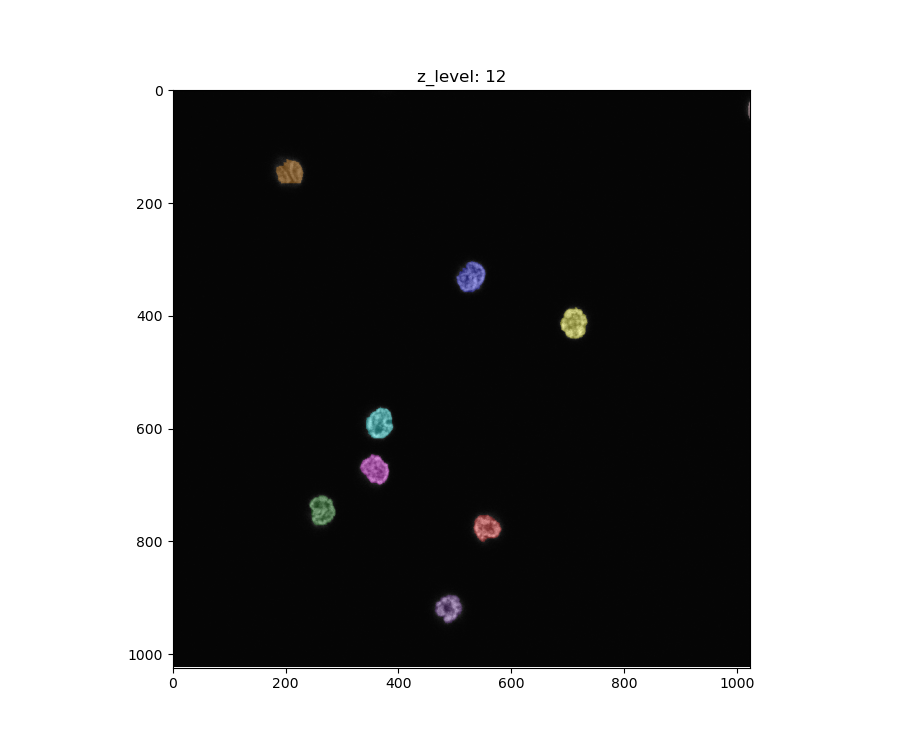

In [64]:
multi_slice_viewer(colored_label_image)

## 2b. Crop segmented instances

### 2b. i) Conservative crop

We now crop the segmented using a rectangular crop for all individual labeled elements where the crop spans all z-dimensions and the maximum x and y dimension for each label. Note that if we have overlaying objects that is likely to yield fragments of the other objects as well.

To this end we first obtain the region properties for the detected nuclei (objects).

In [69]:
nuclei_properties = regionprops(labels, intensity_image = normalized_img)

In [100]:
nuclei_dicts = get_conservative_nuclear_crops(labels, normalized_img)

---

## 2c. Filter nuclei crops

We now filter out crops that do not represent desired nuclei samples because they e.g. show cut-off or mitotic nuclei, as well as debris.

To this end we apply a size filter to the detected nuclei. For that we first obtain the size of a single pixel in the image from the metadata.

In [30]:
microns_per_pixel = data_dict['metadata']['pixel_microns']

In [138]:
filtered_nuclei_dicts, filtered_out_nuclei_dicts = filter_nuclei_by_size(nuclei_dicts, 0.1, 10, 200)

21.317000000000004
21.031000000000006
21.420000000000005
20.831000000000007
21.523000000000007
21.408000000000005
19.063000000000006
22.095000000000006
1.4980000000000004
0.023000000000000007


Let us quickly inspect the filtered out objects.

<IPython.core.display.Javascript object>


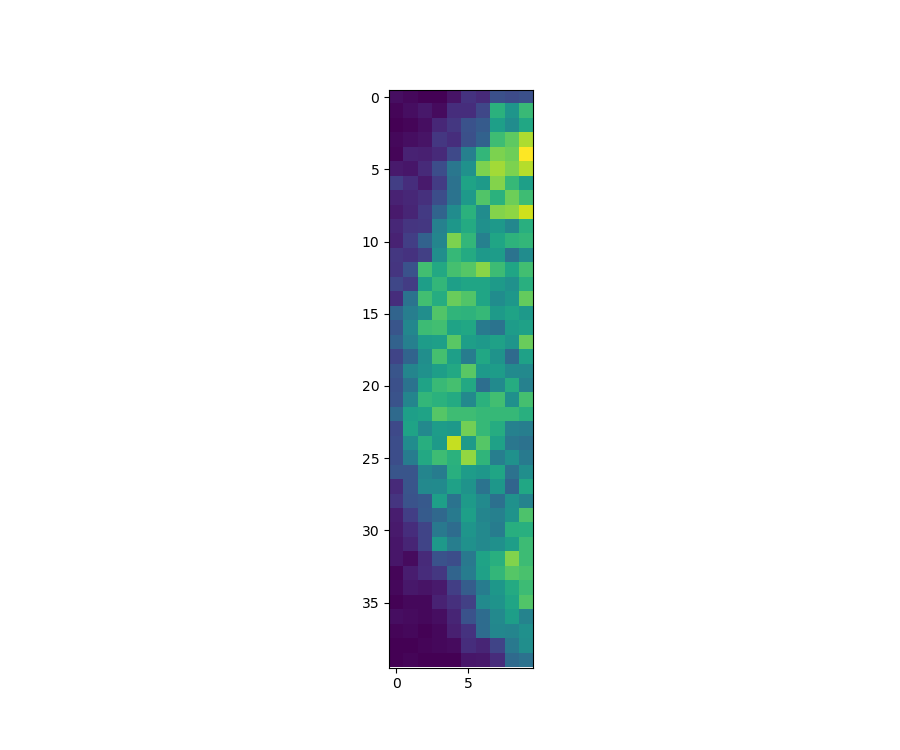

<IPython.core.display.Javascript object>


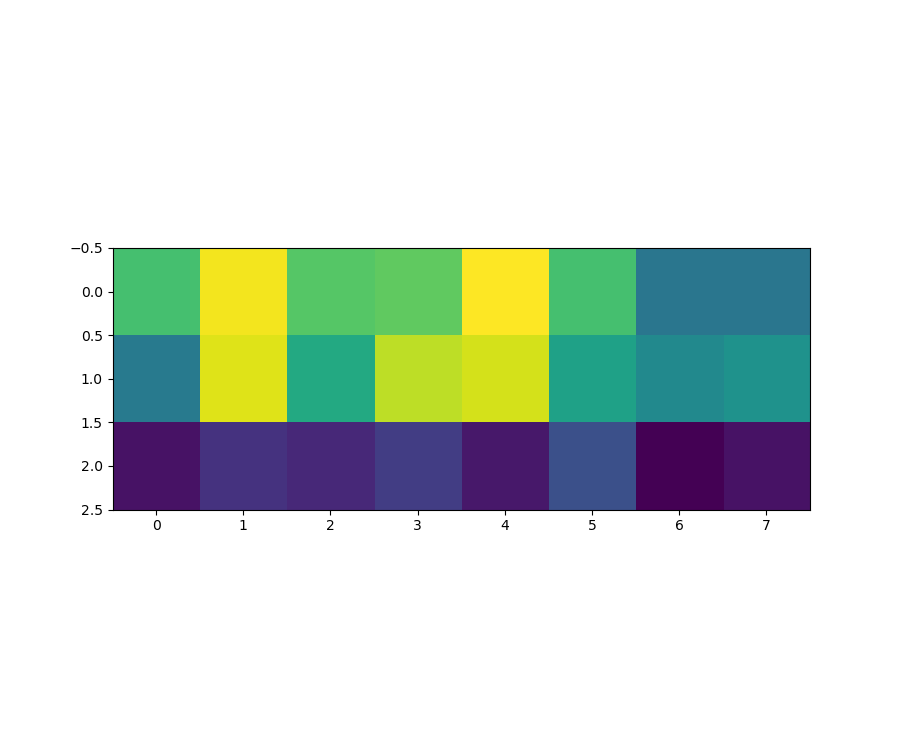

In [139]:
for nucleus_dict in filtered_out_nuclei_dicts:
    multi_slice_viewer(nucleus_dict['image'])

This seemed to have worked as expected.

---

#  3. Save the results

We finally save the obtained images of the individual nuclei to disk as a .tiff file.

In [140]:
base_path = '/home/daniel/Desktop/processing/11J1_CD4T_488Coro1A_555RPL10A_D001'
for i in range(len(filtered_nuclei_dicts)):
    save_npy_as_tiff(filtered_nuclei_dicts[i]['image'], base_path+'_{}.tiff'.format(i))